# Выбор локации для скважины

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Загрузим необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import random

In [2]:
import warnings
warnings.filterwarnings("ignore")

Создаем путь к файлам с данными.

In [3]:
path_1 = '/datasets/geo_data_0.csv' # первый регион 
path_2 = '/datasets/geo_data_1.csv' # второй регион
path_3 = '/datasets/geo_data_2.csv' # третий регион

### Первый регион

Откроем файл с информацией о первом регионе.

In [4]:
try:
    df_1 = pd.read_csv(path_1)
except Exception as err:
    try:
        df_1 = pd.read_csv(path_1[10:])
    except Exception as err:
        print('Ошибка чтения файла:', repr(err))

In [5]:
df_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [6]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Таблица представлена 100000 строк, каждая из которых отдельная скважина в регионе, и 5 колонками.

#### Данные в колонках 
<a id='data'> </a>

В таблице представлена следующая информация:
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

    - Данные в колонке `product` являются **целевым признаком**.
    - Информация об уникальном идентификаторе скважины в дальнейшем нам не понадобится.

In [7]:
df_1.drop('id', axis=1, inplace=True)

Мы не знаем, что означают данные, кроме объема запасов в скважине, однако будет хорошо всё равно увидеть их распределение.

#### Признак f0

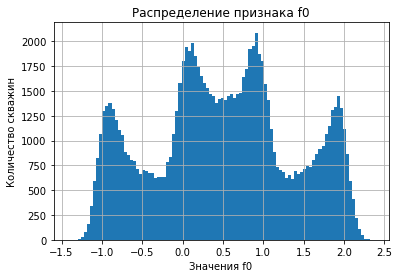

In [8]:
df_1.f0.hist(
    bins=100
)
plt.title('Распределение признака f0')
plt.ylabel('Количество скважин')
plt.xlabel('Значения f0')
plt.show()

In [9]:
df_1.f0.describe()

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64

Распределение признака не близко к нормальному.

Посмотрим на взаимосвязь признака f0 с целевым.

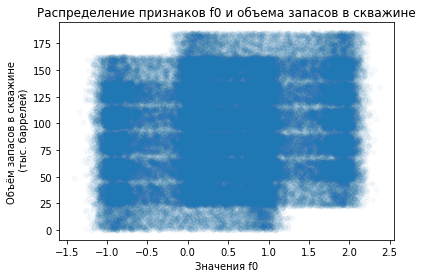

In [10]:
df_1.plot(x='f0', y='product', kind='scatter', alpha=0.03)
plt.title('Распределение признаков f0 и объема запасов в скважине')
plt.ylabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.xlabel('Значения f0')
plt.show()

In [11]:
df_1['f0'].corr(df_1['product'])

0.1435363509318926

Кажется, словно видимой взаимосвязи между f0 и целевым признаком нет.

#### Признак f1

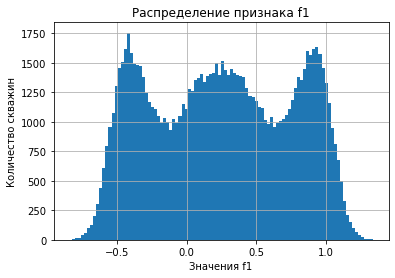

In [12]:
df_1.f1.hist(bins=100)
plt.title('Распределение признака f1')
plt.ylabel('Количество скважин')
plt.xlabel('Значения f1')
plt.show()

In [13]:
df_1.f1.describe()

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64

Распределение признака не близко к нормальному.

Посмотрим на взаимосвязь признака f1 с целевым.

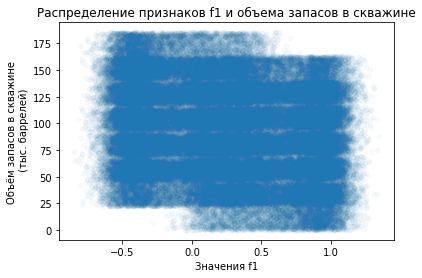

In [14]:
df_1.plot(x='f1', y='product', kind='scatter', alpha=0.03)
plt.title('Распределение признаков f1 и объема запасов в скважине')
plt.ylabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.xlabel('Значения f1')
plt.show()

In [15]:
df_1['f1'].corr(df_1['product'])

-0.19235576281513286

Кажется, словно видимой взаимосвязи между f1 и целевым признаком нет.

#### Признак f2

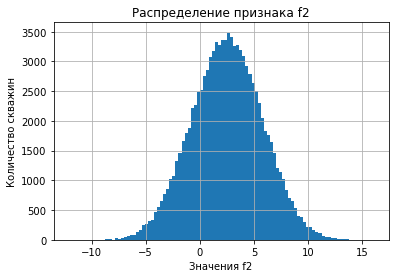

In [16]:
df_1.f2.hist(bins=100)
plt.title('Распределение признака f2')
plt.ylabel('Количество скважин')
plt.xlabel('Значения f2')
plt.show()

In [17]:
df_1.f2.describe()

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64

Распределение признака f2 близко к нормальному.

Посмотрим на взаимосвязь признака f2 с целевым.

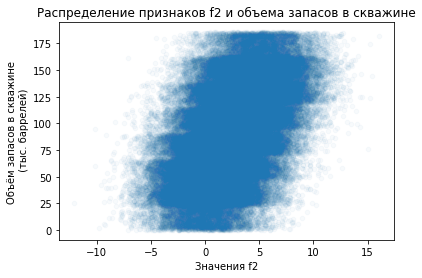

In [18]:
df_1.plot(x='f2', y='product', kind='scatter', alpha=0.03)
plt.title('Распределение признаков f2 и объема запасов в скважине')
plt.ylabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.xlabel('Значения f2')
plt.show()

In [19]:
df_1['f2'].corr(df_1['product'])

0.48366328692615235

Признак f2 имеет несильную линейную корреляцию с целевым признаком.

#### Мультиколлинеарность

Проверим, нет ли мультиколлинеарности факторов.

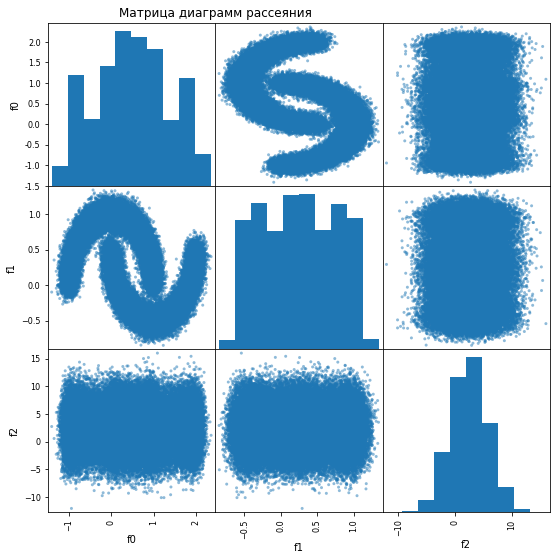

In [20]:
pd.plotting.scatter_matrix(df_1.drop('product', axis=1), figsize=(9, 9), alpha=0.5)
plt.title('Матрица диаграмм рассеяния', x=-1, y=3)
plt.show()

In [21]:
df_1.drop('product', axis=1).corr()

,f0,f1,f2
f0,1.000000,-0.440723,-0.003153
f1,-0.440723,1.000000,0.001724
f2,-0.003153,0.001724,1.000000


Мультиколлинеарности факторов для первого региона не обнаружено.

#### Целевой признак

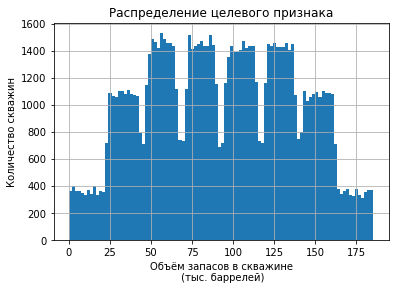

In [22]:
df_1['product'].hist(
    bins=100
)
plt.title('Распределение целевого признака')
plt.ylabel('Количество скважин')
plt.xlabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.show()

In [23]:
df_1['product'].describe()

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

Целевой признак в регионе распределен мультимодально.

### Второй регион

Откроем файл с информацией о втором регионе.

In [24]:
try:
    df_2 = pd.read_csv(path_2)
except Exception as err:
    try:
        df_2 = pd.read_csv(path_2[10:])
    except Exception as err:
        print('Ошибка чтения файла:', repr(err))

In [25]:
df_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [26]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Таблица представлена 100000 строк, каждая из которых отдельная скважина в регионе, и 5 колонками.

Данные по второму региону соответсвуют [данным по первому региону](#data)

Удалим столбец с идентификатором скважин.

In [27]:
df_2.drop('id', axis=1, inplace=True)

Посмотрим на распределение признаков.

#### Признак f0

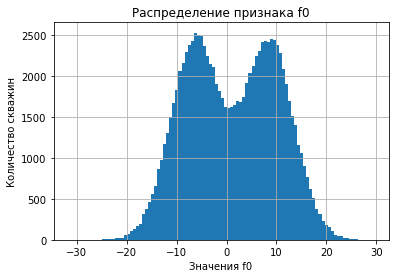

In [28]:
df_2.f0.hist(bins=100)
plt.title('Распределение признака f0')
plt.ylabel('Количество скважин')
plt.xlabel('Значения f0')
plt.show()

In [29]:
df_2.f0.describe()

count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64

В отличие от первого региона во втором признак f0 имеет бимодальное распределение.

Посмотрим на взаимосвязь признака f0 с целевым.

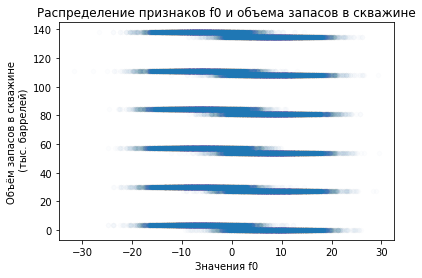

In [30]:
df_2.plot(x='f0', y='product', kind='scatter', alpha=0.01)
plt.title('Распределение признаков f0 и объема запасов в скважине')
plt.ylabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.xlabel('Значения f0')
plt.show()

In [31]:
df_2['f0'].corr(df_2['product'])

-0.030490530564375243

Видимой корреляции между признаками нет.

#### Признак f1

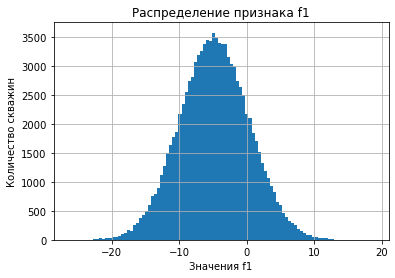

In [32]:
df_2.f1.hist(bins=100)
plt.title('Распределение признака f1')
plt.ylabel('Количество скважин')
plt.xlabel('Значения f1')
plt.show()

In [33]:
df_2.f1.describe()

count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64

У признака f1 нормальное распределение, в отличие от первого региона.

Посмотрим на взаимосвязь признака f1 с целевым.

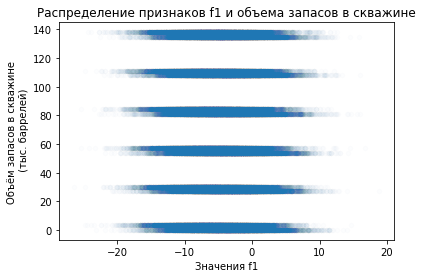

In [34]:
df_2.plot(x='f1', y='product', kind='scatter', alpha=0.01)
plt.title('Распределение признаков f1 и объема запасов в скважине')
plt.ylabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.xlabel('Значения f1')
plt.show()

In [35]:
df_2['f1'].corr(df_2['product'])

-0.010154931786466105

Видимой корреляции между признаками нет.

#### Признак f2

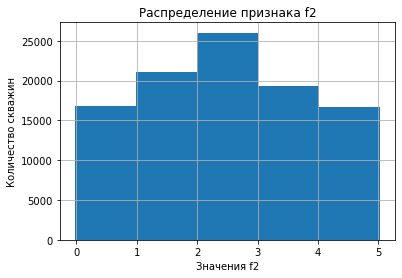

In [36]:
df_2.f2.hist(
    bins=5
)
plt.title('Распределение признака f2')
plt.ylabel('Количество скважин')
plt.xlabel('Значения f2')
plt.show()

In [37]:
df_2.f2.describe()

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64

Распределение признака f2 не близко к нормальному.

Посмотрим на взаимосвязь признака f2 с целевым.

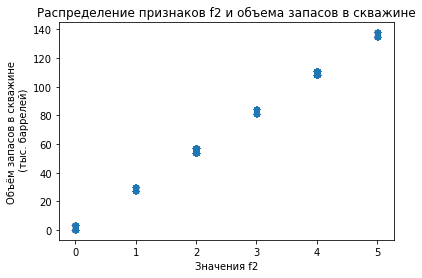

In [38]:
df_2.plot(x='f2', y='product', kind='scatter', alpha=0.01)
plt.title('Распределение признаков f2 и объема запасов в скважине')
plt.ylabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.xlabel('Значения f2')
plt.show()

In [39]:
df_2['f2'].corr(df_2['product'])

0.9993969704906556

Между признаками есть сильная линейная связь  - либо утечка данных, либо тот самый золотой признак. Не зная, какие признаки мы исследуем, удалять их мы не будем.

#### Мультиколлинеарность

Проверим, нет ли мультиколлинеарности факторов.

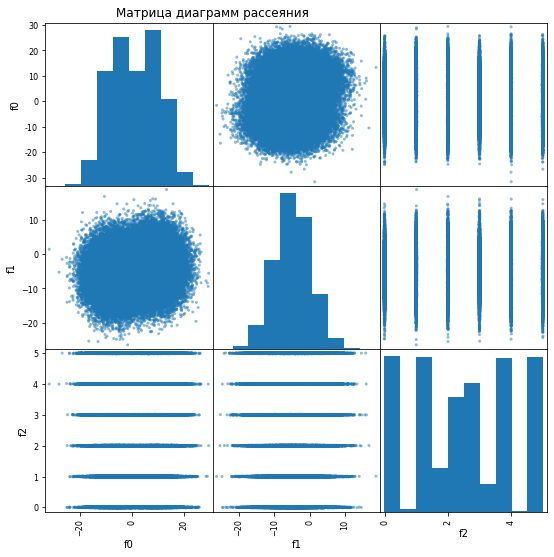

In [40]:
pd.plotting.scatter_matrix(df_2.drop('product', axis=1), figsize=(9, 9), alpha=0.5)
plt.title('Матрица диаграмм рассеяния', x=-1, y=3)
plt.show()

In [41]:
df_2.drop('product', axis=1).corr()

,f0,f1,f2
f0,1.000000,0.182287,-0.001777
f1,0.182287,1.000000,-0.002595
f2,-0.001777,-0.002595,1.000000


Мультиколлинеарности факторов для второго региона не обнаружено.

#### Целевой признак

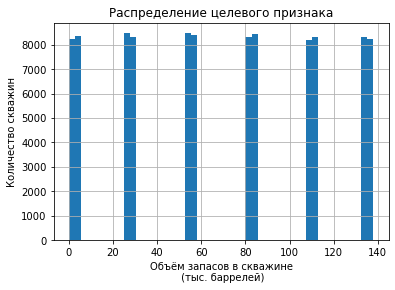

In [42]:
df_2['product'].hist(
    bins=50
)
plt.title('Распределение целевого признака')
plt.ylabel('Количество скважин')
plt.xlabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.show()

In [43]:
df_2['product'].describe()

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

Распрделенение целевого признака во втором регионе далеко от нормального.

### Третий регион

Откроем файл с информацией о третьем регионе.

In [44]:
try:
    df_3 = pd.read_csv(path_3)
except Exception as err:
    try:
        df_3 = pd.read_csv(path_3[10:])
    except Exception as err:
        print('Ошибка чтения файла:', repr(err))

In [45]:
df_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [46]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Таблица представлена 100000 строк, каждая из которых отдельная скважина в регионе, и 5 колонками.

Данные по третьему региону соответсвуют [данным по первому региону](#data)

Удалим столбец с идентификатором скважин.

In [47]:
df_3.drop('id', axis=1, inplace=True)

Посмотрим на распределение признаков.

#### Признак f0

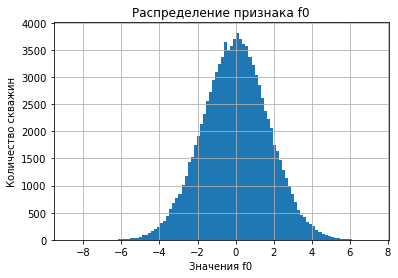

In [48]:
df_3.f0.hist(
    bins=100
)
plt.title('Распределение признака f0')
plt.ylabel('Количество скважин')
plt.xlabel('Значения f0')
plt.show()

In [49]:
df_3.f0.describe()

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64

В отличие от первого и второго региона третий регион имеет близкое к нормальному распределение признака f0.

Посмотрим на взаимосвязь признака f0 с целевым.

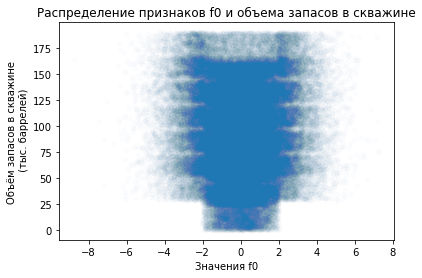

In [50]:
df_3.plot(x='f0', y='product', kind='scatter', alpha=0.01)
plt.title('Распределение признаков f0 и объема запасов в скважине')
plt.ylabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.xlabel('Значения f0')
plt.show()

In [51]:
df_3['f0'].corr(df_3['product'])

-0.0019870619990491356

Видимой корреляции между признаками нет.

#### Признак f1

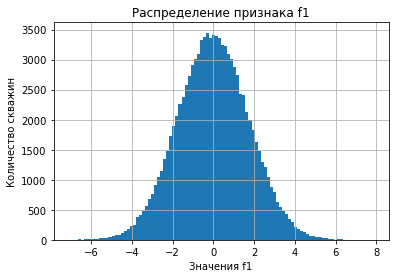

In [52]:
df_3.f1.hist(
    bins=100
)
plt.title('Распределение признака f1')
plt.ylabel('Количество скважин')
plt.xlabel('Значения f1')
plt.show()

In [53]:
df_3.f1.describe()

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64

У признака f1 нормальное распределение как и у второго региона, в отличие от первого региона.

Посмотрим на взаимосвязь признака f1 с целевым.

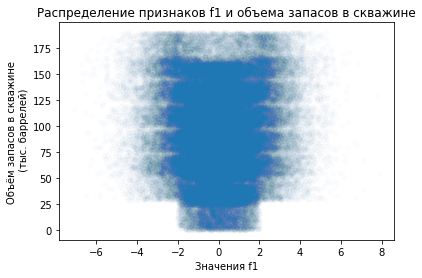

In [54]:
df_3.plot(x='f1', y='product', kind='scatter', alpha=0.01)
plt.title('Распределение признаков f1 и объема запасов в скважине')
plt.ylabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.xlabel('Значения f1')
plt.show()

In [55]:
df_3['f1'].corr(df_3['product'])

-0.0010123938161309012

Видимой корреляции между признаками нет.

#### Признак f2

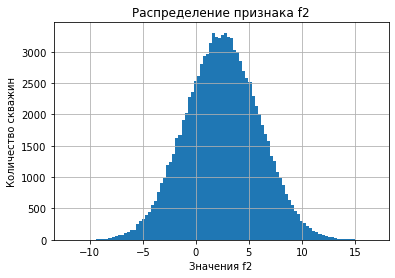

In [56]:
df_3.f2.hist(
    bins=100
)
plt.title('Распределение признака f2')
plt.ylabel('Количество скважин')
plt.xlabel('Значения f2')
plt.show()

In [57]:
df_3.f2.describe()

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64

Распределение признака f2 близко к нормальному.

Посмотрим на взаимосвязь признака f2 с целевым.

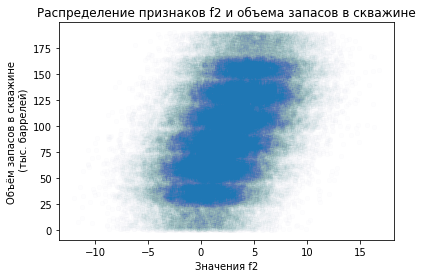

In [58]:
df_3.plot(x='f2', y='product', kind='scatter', alpha=0.009)
plt.title('Распределение признаков f2 и объема запасов в скважине')
plt.ylabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.xlabel('Значения f2')
plt.show()

In [59]:
df_3['f2'].corr(df_3['product'])

0.4458710915574206

Признак f2 имеет несильную линейную корреляцию с целевым признаком.

#### Мультиколлинеарность

Проверим, нет ли мультиколлинеарности факторов.

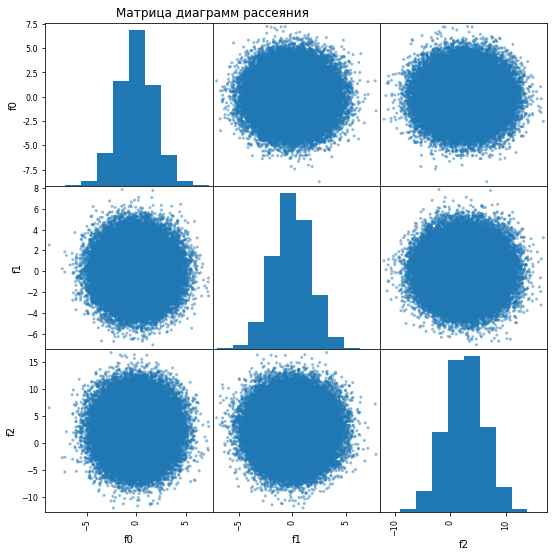

In [60]:
pd.plotting.scatter_matrix(df_3.drop('product', axis=1), figsize=(9, 9), alpha=0.5)
plt.title('Матрица диаграмм рассеяния', x=-1, y=3)
plt.show()

In [61]:
df_3.drop('product', axis=1).corr()

,f0,f1,f2
f0,1.000000,0.000528,-0.000448
f1,0.000528,1.000000,0.000779
f2,-0.000448,0.000779,1.000000


Мультиколлинеарности факторов для третьего региона не обнаружено.

#### Целевой признак

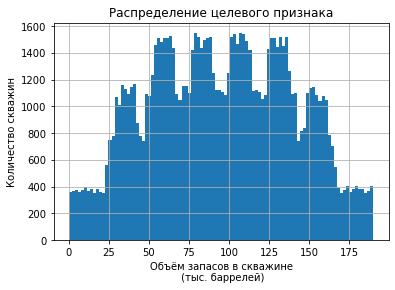

In [62]:
df_3['product'].hist(
    bins=100
)
plt.title('Распределение целевого признака')
plt.ylabel('Количество скважин')
plt.xlabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.show()

In [63]:
df_3['product'].describe()

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

Распределение целевого признака в третьем регионе по форме похоже на распределение в первом регионе и так же являтся мультимодальным.

## Обучение и проверка модели

Создадим переменную для значения random_state при обучении моделей.

In [64]:
state = 12345

Обучим и проверим модель для каждого региона:
- разобьем данные на обучающую и валидационную выборки в соотношении 75:25.
- обучим модель и сделаем предсказания на валидационной выборке.
- сохраним предсказания и правильные ответы на валидационной выборке.
- выведем на экран средний запас предсказанного сырья и RMSE модели.
- проанализируем результаты.

### Разделение на выборки

Разделим данные на признаки и целевой признак.

In [65]:
# первый регион
# признаки 
features_1 = df_1.drop('product', axis=1)
# целевой признак 
target_1 = df_1['product']

# второй регион
# признаки 
features_2 = df_2.drop('product', axis=1)
# целевой признак 
target_2 = df_2['product']

# третий регион
# признаки 
features_3 = df_3.drop('product', axis=1)
# целевой признак 
target_3 = df_3['product']

Разобъем данные на обучающую и валидационную выборки в пропорциях 75:25.

In [66]:
# первый регион
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, 
    target_1, 
    test_size=0.25,
    random_state=state,
    shuffle=True
)

In [67]:
# второй регион
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, 
    target_2, 
    test_size=0.25,
    random_state=state,
    shuffle=True
)

In [68]:
# третий регион
features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(
    features_3, 
    target_3, 
    test_size=0.25,
    random_state=state,
    shuffle=True
)

Посмотрим на размеры выборок.

In [69]:
features_train_1.shape, features_valid_1.shape, \
features_train_2.shape, features_valid_2.shape, \
features_train_3.shape, features_valid_3.shape

((75000, 3), (25000, 3), (75000, 3), (25000, 3), (75000, 3), (25000, 3))

Пропорции 75:25 выдержаны.

Оценим равномерность распределения целевого признака по выборкам.

**Первый регион**

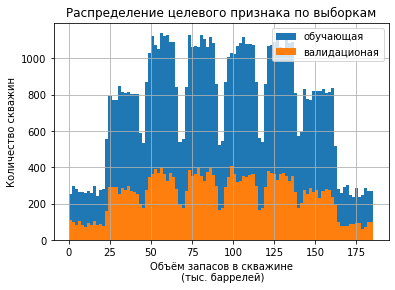

In [70]:
target_train_1.hist(
    bins=100
)
target_valid_1.hist(
    bins=100
)
plt.legend(['обучающая', 'валидационая'])
plt.title('Распределение целевого признака по выборкам')
plt.ylabel('Количество скважин')
plt.xlabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.show()

Выборки распределены по целевому признаку равномерно.

**Второй регион**

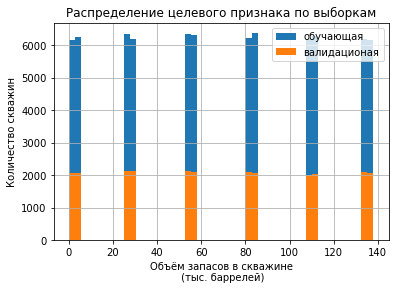

In [71]:
target_train_2.hist(
    bins=50
)
target_valid_2.hist(
    bins=50
)
plt.legend(['обучающая', 'валидационая'])
plt.title('Распределение целевого признака по выборкам')
plt.ylabel('Количество скважин')
plt.xlabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.show()

Выборки распределены по целевому признаку равномерно.

**Третий регион**

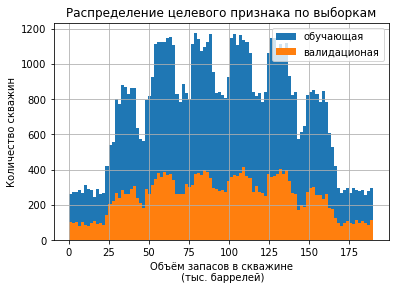

In [72]:
target_train_3.hist(
    bins=100
)
target_valid_3.hist(
    bins=100
)
plt.legend(['обучающая', 'валидационая'])
plt.title('Распределение целевого признака по выборкам')
plt.ylabel('Количество скважин')
plt.xlabel('Объём запасов в скважине\n (тыс. баррелей)')
plt.show()

Выборки распределены по целевому признаку равномерно.

### Масштабирование признаков

Масштабируем данные, хранящиеся в выборках, используя стандартизацию.

Создадим объект структуры `StandardScaler` и настроим его на обучающих данных. Настройка — это вычисление среднего и дисперсии.

In [73]:
# настройка признаков первого региона
scaler_1 = StandardScaler()
scaler_1.fit(features_train_1)

# настройка признаков второго региона
scaler_2 = StandardScaler()
scaler_2.fit(features_train_2)

# настройка признаков третьего региона
scaler_3 = StandardScaler()
scaler_3.fit(features_train_3)

StandardScaler()

    Преобразуем обучающую и валидационную выборки функцией `transform()`.

In [74]:
pd.options.mode.chained_assignment = None

# стандартизация признаков первого региона
features_train_1 = scaler_1.transform(features_train_1)
features_valid_1 = scaler_1.transform(features_valid_1)

# стандартизация признаков второго региона
features_train_2 = scaler_2.transform(features_train_2)
features_valid_2 = scaler_2.transform(features_valid_2)

# стандартизация признаков третьего региона
features_train_3 = scaler_3.transform(features_train_3)
features_valid_3 = scaler_3.transform(features_valid_3)

### Обучение моделей

Обучим модели для каждого региона. 

Используем модель линейной регрессии. 

Для оценки качества обучения моделей посмотрим на `RMSE` - квадратный корень из среднеквадратичной ошибки модели и коэффициент детерминации, или метрика `R2`, которая вычисляет долю среднеквадратичной ошибки модели от `MSE` среднего, а затем вычитает
эту величину из единицы. Увеличение метрики `R2` означает прирост качества модели.

In [75]:
# модель для первого региона
model_1 = LinearRegression().fit(features_train_1, target_train_1)
prediction_valid_1 = pd.Series(model_1.predict(features_valid_1), index=target_valid_1.index)
mean_1 = prediction_valid_1.mean()

rmse_1 = mean_squared_error(target_valid_1, prediction_valid_1) ** 0.5

print('Модель первого региона')
print()
print('R2 на обучающем наборе:', model_1.score(features_train_1, target_train_1))
print('R2 на валидационном наборе:', model_1.score(features_valid_1, target_valid_1))
print()
print('Средний запас предсказанного сырья:', mean_1)
print('RMSE на валидационном наборе:', rmse_1)

Модель первого региона

R2 на обучающем наборе: 0.27423906493940775
R2 на валидационном наборе: 0.27994321524487786

Средний запас предсказанного сырья: 92.59256778438008
RMSE на валидационном наборе: 37.5794217150813


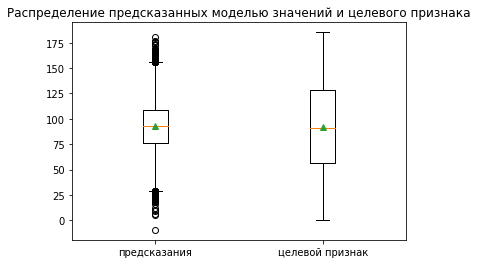

In [76]:
plt.boxplot([prediction_valid_1, target_valid_1], labels=['предсказания', 'целевой признак'], showmeans=True)
plt.title('Распределение предсказанных моделью значений и целевого признака')
plt.show()

Значение `R2` в районе 0.27 указывает на не очень хорошее качество модели, однако можно увидеть, что результаты на обучающем и тестовом наборах очень схожи между собой. Возможность переобучения низка.

`RMSE` для модели превышает 37.57 тыс. баррелей при среднем запасе предсказанного сырья в 92.59 тыс. баррелей.

In [77]:
# модель для второго региона
model_2 = LinearRegression().fit(features_train_2, target_train_2)
prediction_valid_2 = pd.Series(model_2.predict(features_valid_2), index=target_valid_2.index)
mean_2 = prediction_valid_2.mean()

rmse_2 = mean_squared_error(target_valid_2, prediction_valid_2) ** 0.5

print('Модель второго региона')
print()
print('R2 на обучающем наборе:', model_2.score(features_train_2, target_train_2))
print('R2 на валидационном наборе:', model_2.score(features_valid_2, target_valid_2))
print()
print('Средний запас предсказанного сырья:', mean_2)
print('RMSE на валидационном наборе:', rmse_2)

Модель второго региона

R2 на обучающем наборе: 0.9996247760326118
R2 на валидационном наборе: 0.9996233978805127

Средний запас предсказанного сырья: 68.7285468954458
RMSE на валидационном наборе: 0.893099286775617


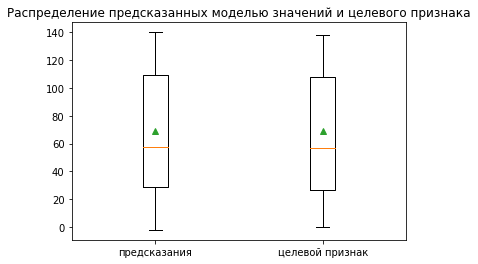

In [78]:
plt.boxplot([prediction_valid_2, target_valid_2], labels=['предсказания', 'целевой признак'], showmeans=True)
plt.title('Распределение предсказанных моделью значений и целевого признака')
plt.show()

Модель хорошо обучилась: `R2` показал большие значения и `RMSE` для модели ниже 0.89 тыс. баррелей.

In [79]:
# модель для третьего региона
model_3 = LinearRegression().fit(features_train_3, target_train_3)
prediction_valid_3 = pd.Series(model_3.predict(features_valid_3), index=target_valid_3.index)
mean_3 = prediction_valid_3.mean()

rmse_3 = mean_squared_error(target_valid_3, prediction_valid_3) ** 0.5

print('Модель третьего региона')
print()
print('R2 на обучающем наборе:', model_3.score(features_train_3, target_train_3))
print('R2 на валидационном наборе:', model_3.score(features_valid_3, target_valid_3))
print()
print('Средний запас предсказанного сырья:', mean_3)
print('RMSE на валидационном наборе:', rmse_3)

Модель третьего региона

R2 на обучающем наборе: 0.19661432867329998
R2 на валидационном наборе: 0.20524758386040465

Средний запас предсказанного сырья: 94.96504596800506
RMSE на валидационном наборе: 40.02970873393434


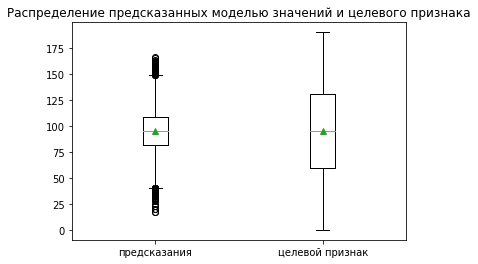

In [80]:
plt.boxplot([prediction_valid_3, target_valid_3], labels=['предсказания', 'целевой признак'], showmeans=True)
plt.title('Распределение предсказанных моделью значений и целевого признака')
plt.show()

Значение `R2` в районе 0.2 так же указывают на не очень хорошее качество модели. 

`RMSE` для модели превышает 40.03 тыс. баррелей при среднем запасе предсказанного сырья в 94.97 тыс. баррелей.

**Вывод**

Модель для второго региона обучилась хорошо, показала низкое значение RMSE и высокие значения R2. Для остальных моделей качество предсказаний не столь велико и значения RMSE составляют 38-40 тыс. баррелей при среднем запасе предсказанного сырья в 93-95 тыс. баррелей.

## Подготовка к расчёту прибыли

3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.

3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.

3.3. Напишите выводы по этапу подготовки расчёта прибыли.


Нам известны следующие условия:

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

- Бюджет на разработку скважин в регионе — 10 млрд рублей.

- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Сохраним ключевые значения для расчётов в отдельных переменных.

In [81]:
# количество скважин при разведке
EXPLORATION_WELLS = 500
# количество скважин для разработки
DEVELOPMENT_WELLS = 200
# бюджет на разработку скважин в регионе
BUDGET = 10000000000
# доход с каждой единицы продукта (тыс. баррелей)
INCOME = 450000

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [82]:
loss_free_well = BUDGET / DEVELOPMENT_WELLS / INCOME
loss_free_well

111.11111111111111

Мы получили достаточный объем сырья в скважине для её безубыточной разработки. Сравним со средними запасами по скважине в каждом регионе.

In [83]:
print(f'Для безубыточной разработки скважина должна содержать {loss_free_well:.2f} тыс. баррелеей.')
print(f'Средний объем сырья в скважинах первого региона {mean_1:.2f} тыс.баррелей.')
print(f'Средний объем сырья в скважинах второго региона {mean_2:.2f} тыс.баррелей.')
print(f'Средний объем сырья в скважинах третьего региона {mean_3:.2f} тыс.баррелей.')

Для безубыточной разработки скважина должна содержать 111.11 тыс. баррелеей.
Средний объем сырья в скважинах первого региона 92.59 тыс.баррелей.
Средний объем сырья в скважинах второго региона 68.73 тыс.баррелей.
Средний объем сырья в скважинах третьего региона 94.97 тыс.баррелей.


Выходит, что усредненная скважина каждого региона - убыточна. Но так как бурят 500 и из них отбирают 200 лучших, есть шанс выйти на безубыточную разработку и даже заработать.

Напишем функцию для рассчета прибыли по выбранным скважинам и предсказаниям модели:
- выберем скважины с максимальными значениями предсказаний
- просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям
- рассчитаем прибыль для полученного объема сырья

In [84]:
def total_income(predictions, target, count=DEVELOPMENT_WELLS, price=INCOME, developer_budget=BUDGET):
    '''
    функция принимает на вход предсказания модели predictions, сортирует их по убыванию, 
    потом суммирует соответствующие значения целевого признака target 
    до ограничителя count (количество скважин) и умножает на цену (price), по умолчанию равную income 
    (доход с каждой единицы продукта (тыс. баррелей))
    функция возвращает прибыль от разработки скважин в количестве count за вычетом бюджета, 
    потраченного на разработку developer_BUDGET
    '''
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:count]
    result = selected.sum() * price - developer_budget
    return result

## Расчёт прибыли и рисков 

Посчитаем риски и прибыль для каждого региона:
- применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли
- найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль
- предложим регион для разработки скважин

In [85]:
state = np.random.RandomState(12345)

Напишем функцию для бутстрапинга выборок в каждом регионе.

In [86]:
def bootstrap_region(prediction_region, target_region):
    values = []
    for i in range(1000):
        predictions_subsample = prediction_region.sample(n=EXPLORATION_WELLS, replace=True, random_state=state)
        target_subsample = target_region[predictions_subsample.index]
        value = total_income(predictions_subsample, target_subsample)
        values.append(value)
    return values

In [87]:
income_region_1 = bootstrap_region(prediction_valid_1, target_valid_1)
income_region_2 = bootstrap_region(prediction_valid_2, target_valid_2)
income_region_3 = bootstrap_region(prediction_valid_3, target_valid_3)

Посмотрим на распределение получившейся прибыли.

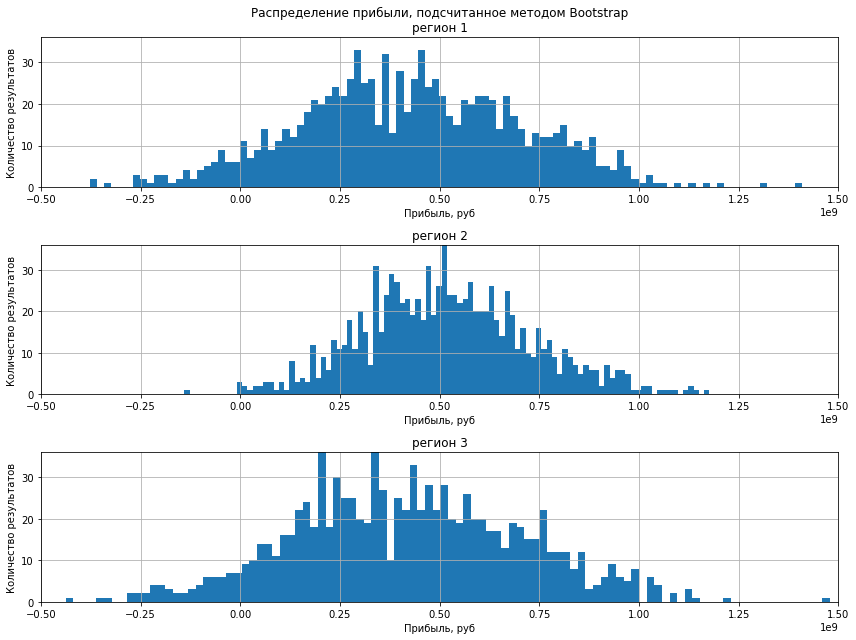

In [88]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9))
axes[0].hist(income_region_1, bins=100)
axes[0].set_title('Распределение прибыли, подсчитанное методом Bootstrap\nрегион 1')

axes[1].hist(income_region_2, bins=100)
axes[1].set_title('регион 2')

axes[2].hist(income_region_3, bins=100)
axes[2].set_title('регион 3')

axes[0].set_ylabel('Количество результатов')
axes[1].set_ylabel('Количество результатов')
axes[2].set_ylabel('Количество результатов')

axes[0].set_xlabel('Прибыль, руб')
axes[1].set_xlabel('Прибыль, руб')
axes[2].set_xlabel('Прибыль, руб')

axes[0].grid()
axes[1].grid()
axes[2].grid()


axes[0].set_xlim(-0.5*10**9, 1.5*10**9)
axes[1].set_xlim(-0.5*10**9, 1.5*10**9)
axes[2].set_xlim(-0.5*10**9, 1.5*10**9)

axes[0].set_ylim(0, 36)
axes[1].set_ylim(0, 36)
axes[2].set_ylim(0, 36)

fig.tight_layout()
plt.show()

In [89]:
print(f'Средняя прибыль региона 1: {np.mean(income_region_1):.0f}')
print(f'Средняя прибыль региона 2: {np.mean(income_region_2):.0f}')
print(f'Средняя прибыль региона 3: {np.mean(income_region_3):.0f}')


Средняя прибыль региона 1: 425938527
Средняя прибыль региона 2: 518259494
Средняя прибыль региона 3: 420194005


Второй регион имеет самую большую среднюю прибыль.

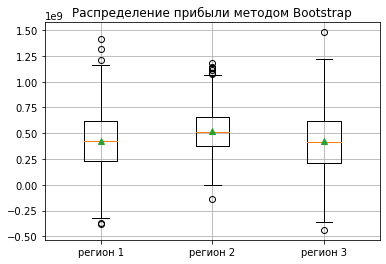

In [90]:
plt.boxplot([income_region_1, income_region_2, income_region_3], labels=['регион 1', 'регион 2', 'регион 3'], showmeans=True)
plt.title('Распределение прибыли методом Bootstrap')
plt.grid()
plt.show()

Видим, что вторая модель по разбросу выглядит перспективнее в плане получения прибыли: средняя прибыль региона выше, значений, показавших убытки, меньше по сравнению с другими регионами.

Рассчитаем доверительные интервалы для каждого региона.

In [91]:
def confidence_interval_95(values):
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    return (lower, upper)

In [92]:
income_interval_1 = confidence_interval_95(income_region_1)
income_interval_2 = confidence_interval_95(income_region_2)
income_interval_3 = confidence_interval_95(income_region_3)

In [93]:
print('Доверительный 95% интервал составляет')
print('Для региона 1:', income_interval_1)
print('Для региона 2:', income_interval_2)
print('Для региона 3:', income_interval_3)

Доверительный 95% интервал составляет
Для региона 1: (-102090094.83793654, 947976353.3583689)
Для региона 2: (128123231.43308444, 953612982.0669085)
Для региона 3: (-115852609.16001143, 989629939.8445739)


В 95% доверительный интервал только второго региона не входят отрицательные значения.

Подсчитаем риск убытков для каждого региона.

In [94]:
print('Риск убытков для каждого региона составил:')
print(f'Для региона 1: {(pd.Series(income_region_1) < 0).mean():.1%}')
print(f'Для региона 2: {(pd.Series(income_region_2) < 0).mean():.1%}')
print(f'Для региона 3: {(pd.Series(income_region_3) < 0).mean():.1%}')

Риск убытков для каждого региона составил:
Для региона 1: 6.0%
Для региона 2: 0.3%
Для региона 3: 6.2%


Регион 2 показал наименьшие риски для разработки.

## Вывод

Было проведено исследование, посвященное определению региона, где добыча принесёт наибольшую прибыль.

Для каждого региона имелись данные по 100000 скважинам, для каждой из которых мы знали три значимых признака и объём запасов в скважине (тыс. баррелей).

Данные каждого региона были разделены на обучающую и валидационную выборки, на которых мы обучили и проверили модели линейной регрессии.

Далее мы смоделировали ситуацию с разведкой и разработкой новых скважин в тех же регионах методом Bootstrap и подсчитали возможную среднюю прибыль. 

Мы выяснили, что для безубыточной разработки скважина должна содержать 111.11 тыс. баррелеей.
- Средний объем сырья в скважинах первого региона 92.59 тыс.баррелей.
- Средний объем сырья в скважинах второго региона 68.73 тыс.баррелей.
- Средний объем сырья в скважинах третьего региона 94.97 тыс.баррелей.

Несмотря на то, что средний объем сырья в скважинах второго региона ниже, чем в остальных, вторая модель обучилась точнее предсказывать объем сырья, что позволило ей точнее предсказывать наиболее перспективные скважины для разработки.

Нами были получены следующие результаты:
- Средняя прибыль 1 региона: 425.938.527 руб.
- **Средняя прибыль 2 региона: 518.259.494 руб.** (наиболее перспективный регион по средней прибыли)
- Средняя прибыль 3 региона: 420.194.005 руб.


Так же мы рассчитали доверительный 95% интервал для прибыли каждого региона:
- Для 1 региона: от -102.090.095 до 947.976.353 руб.
- **Для 2 региона: от 128.123.231 до 953.612.982 руб.** (наиболее перспективный регион по доверительному интервалу прибыли)
- Для 3 региона: от -115.852.609 до 989.629.940 руб.


- Так же согласно проведенному исследованию, **наименьшие риски убытков будут при разработке региона 2** - риск составил всего 0.3%, в отличие от других регионов с рисками в 6.0-6.2%.


- Таким образом, есть основания предположить, что согласно имеющимся данным **второй регион наиболее предпочтителен для разработки**.